In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras as k
from keras import layers
from sklearn.model_selection import train_test_split
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [36]:
# ============================== gpu info ==============================
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print("GPUs: ", tf.config.list_physical_devices("GPU"))

Num GPUs Available:  1
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [37]:
# ============================== variables ==============================
image_size = 256
num_classes = 3

in_channel_spec = 9
in_channel_chip = 3
img_rows, img_cols = image_size, image_size
input_shape_spec = (img_rows, img_cols, in_channel_spec)
input_shape_chip = (img_rows, img_cols, in_channel_chip)

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
epochs = 100

In [38]:
# ============================== paths ==============================
# needed for generate_data
modality = "multi_sc"
exp_name = f"siren"
sub_exp_name = f"base"
model_name = f"{exp_name}_{sub_exp_name}_{modality}"
model_save_path = f"{model_name}.h5"

model_spec_path = f"./{exp_name}_{sub_exp_name}_spec.h5"
model_chip_path = f"./{exp_name}_{sub_exp_name}_chip.h5"

# dataset
csv_path = "../../dataset/labels_sample.csv"
spec_path = "../../dataset/spec"
chip_path = "../../dataset/chip"

In [39]:
# ============================== load/prepare dataset ==============================
df = pd.read_csv(csv_path)

# RANDOM DATASET: we switch to toolbased
# shuffle, need same state for tool/spec/chip/multi
np.random.seed(55)
df = df.iloc[np.random.permutation(len(df))]
# train/test/val : 70/15/15
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, val_df = train_test_split(test_df, test_size=0.5)

print(
    "size check train/test/val",
    len(train_df),
    len(test_df),
    len(val_df),
    (len(train_df) + len(test_df) + len(val_df)),
)

train_df["spec_x"] = train_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")
test_df["spec_x"] = test_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")
val_df["spec_x"] = val_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")

train_df["spec_y"] = train_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")
test_df["spec_y"] = test_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")
val_df["spec_y"] = val_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")

train_df["spec_z"] = train_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")
test_df["spec_z"] = test_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")
val_df["spec_z"] = val_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")

train_df["chip"] = train_df.id.map(lambda id: f"{chip_path}/{id}.jpg")
test_df["chip"] = test_df.id.map(lambda id: f"{chip_path}/{id}.jpg")
val_df["chip"] = val_df.id.map(lambda id: f"{chip_path}/{id}.jpg")

size check train/test/val 14 3 3 20


/home/user/.conda/envs/tf/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

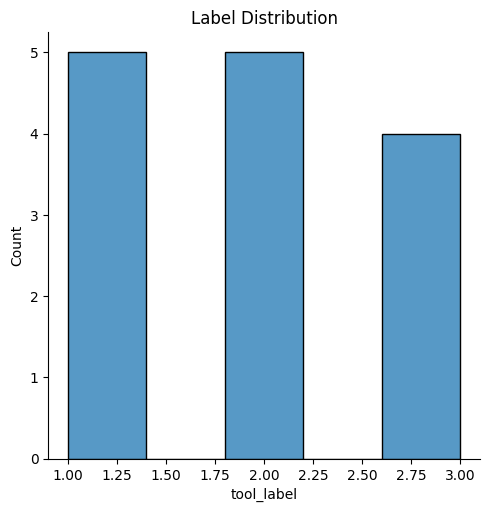

In [40]:
plt.figure(figsize=(6,6))
sns.displot(train_df['tool_label'])
plt.title('Label Distribution')
plt.show()

In [41]:
print("check if permutation is same on all models")
print("train_head", train_df.head())
print("test_head", test_df.head())
print("val_head", val_df.head())

check if permutation is same on all models
train_head          id image_label  tool_label                            spec_x  \
14   T8R3B4       sharp           1   ../../dataset/spec/x/T8R3B4.jpg   
10   T6R9B3        used           2   ../../dataset/spec/x/T6R9B3.jpg   
0    T1R2B1       sharp           1   ../../dataset/spec/x/T1R2B1.jpg   
3   T2R13B4      dulled           3  ../../dataset/spec/x/T2R13B4.jpg   
1    T1R7B4        used           2   ../../dataset/spec/x/T1R7B4.jpg   

                              spec_y                            spec_z  \
14   ../../dataset/spec/y/T8R3B4.jpg   ../../dataset/spec/z/T8R3B4.jpg   
10   ../../dataset/spec/y/T6R9B3.jpg   ../../dataset/spec/z/T6R9B3.jpg   
0    ../../dataset/spec/y/T1R2B1.jpg   ../../dataset/spec/z/T1R2B1.jpg   
3   ../../dataset/spec/y/T2R13B4.jpg  ../../dataset/spec/z/T2R13B4.jpg   
1    ../../dataset/spec/y/T1R7B4.jpg   ../../dataset/spec/z/T1R7B4.jpg   

                              chip  
14   ../../dataset/chip/T

In [42]:
def read_tools(file_paths, img_rows, img_cols, channels):
    """
    Reads the spectogram files from disk and normalizes the pixel values
      @params:
        file_paths - Array of file paths to read from
        img_rows - The image height.
        img_cols - The image width.
        as_grey - Read the image as Greyscale or RGB.
        channels - Number of channels.
      @returns:
        The created and compiled model (Model)
    """
    images = []

    for file_path in file_paths:
        img = cv2.imread(file_path)
        res = cv2.resize(img, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        images.append(res)

    images = np.asarray(images, dtype=np.float32)

    # normalize
    images = images / np.max(images)

    # reshape to match Keras expectaions
    images = images.reshape(images.shape[0], img_rows, img_cols, channels)

    return images


def read_specs(file_paths_x, file_paths_y, file_paths_z, img_rows, img_cols, channels):
    """
    Reads the spectogram files from disk and normalizes the pixel values
      @params:
        file_paths - Array of file paths to read from
        img_rows - The image height.
        img_cols - The image width.
        as_grey - Read the image as Greyscale or RGB.
        channels - Number of channels.
      @returns:
        The created and compiled model (Model)
    """
    images = []

    for i in range(file_paths_x.size):
        img_x = cv2.imread(file_paths_x[i])
        res_x = cv2.resize(
            img_x, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        images.append(res_x)
        img_y = cv2.imread(file_paths_y[i])
        res_y = cv2.resize(
            img_y, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        images.append(res_y)
        img_z = cv2.imread(file_paths_z[i])
        res_z = cv2.resize(
            img_z, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        images.append(res_z)

    images = np.asarray(images, dtype=np.float32)

    # normalize
    images = images / np.max(images)

    # reshape to match Keras expectaions
    images = images.reshape(file_paths_x.shape[0], img_rows, img_cols, channels)

    return images

In [43]:
x_train_spec = read_specs(
    train_df.spec_x.values,
    train_df.spec_y.values,
    train_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel_spec,
)
x_test_spec = read_specs(
    test_df.spec_x.values,
    test_df.spec_y.values,
    test_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel_spec,
)
x_val_spec = read_specs(
    val_df.spec_x.values,
    val_df.spec_y.values,
    val_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel_spec,
)

x_train_chip = read_tools(train_df.chip.values, img_rows, img_cols, in_channel_chip)
x_test_chip = read_tools(test_df.chip.values, img_rows, img_cols, in_channel_chip)
x_val_chip = read_tools(val_df.chip.values, img_rows, img_cols, in_channel_chip)

In [44]:
x_train_spec.shape

(14, 256, 256, 9)

In [45]:
x_train_chip.shape

(14, 256, 256, 3)

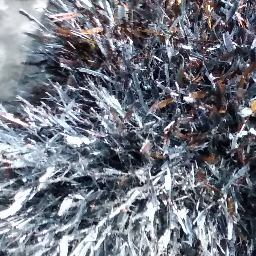

In [46]:
pil_img = tf.keras.utils.array_to_img(x_train_chip[0])
pil_img

In [47]:
labels_train = train_df.tool_label.values
labels_test = test_df.tool_label.values
labels_val = val_df.tool_label.values

labels_train

array([1, 2, 1, 3, 2, 2, 3, 2, 1, 1, 3, 1, 2, 3])

In [48]:
labels_train = labels_train - 1
labels_test = labels_test - 1
labels_val = labels_val - 1

labels_train = tf.keras.utils.to_categorical(
    labels_train, num_classes=num_classes, dtype="float32"
)
labels_test = tf.keras.utils.to_categorical(
    labels_test, num_classes=num_classes, dtype="float32"
)
labels_val = tf.keras.utils.to_categorical(
    labels_val, num_classes=num_classes, dtype="float32"
)

In [49]:
# ============================== augment 1/2 ==============================
data_augmentation_spec = k.Sequential(
    [
        k.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=(0, 1)),
        k.layers.RandomContrast(factor=0.2),
        k.layers.GaussianNoise(stddev=0.2),
    ],
    name="data_augmentation_spec",
)

In [50]:
# ============================== augment 2/2 ==============================
data_augmentation_chip = k.Sequential(
    [
        k.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=(0, 1)),
        k.layers.RandomContrast(factor=0.2),
        k.layers.GaussianNoise(stddev=0.2),
    ],
    name="data_augmentation_chip",
)

In [51]:
x_train_spec = data_augmentation_spec(x_train_spec)
x_train_chip = data_augmentation_chip(x_train_chip)

In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_spec": x_train_spec,
            "input_1_chip": x_train_chip,
        },
        labels_train,
    )
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_spec": x_test_spec,
            "input_1_chip": x_test_chip,
        },
        labels_test,
    )
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_spec": x_val_spec,
            "input_1_chip": x_val_chip,
        },
        labels_val,
    )
)

In [53]:
auto = tf.data.AUTOTUNE
inputs2 = k.Input(input_shape_spec)
inputs3 = k.Input(input_shape_chip)

In [54]:
def generate_datasets(images, is_train=False, shuffle=False):
    dataset = images
    if shuffle:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        pass
    return dataset.prefetch(auto)

In [55]:
train_ds = generate_datasets(train_dataset, is_train=True, shuffle=True)
val_ds = generate_datasets(val_dataset)
test_ds = generate_datasets(test_dataset)

In [56]:
train_ds

<_PrefetchDataset element_spec=({'input_1_spec': TensorSpec(shape=(None, 256, 256, 9), dtype=tf.float32, name=None), 'input_1_chip': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [57]:
model_spec = k.models.load_model(model_spec_path, compile=False)
model_chip = k.models.load_model(model_chip_path, compile=False)

model_spec.trainable = False
model_chip.trainable = False


def load_siren(model_spec, model_chip):
    inputs2 = model_spec.input
    inputs2._name = "input_spec"
    inputs3 = model_chip.input
    inputs3._name = "input_chip"

    truncated_model_spec = k.Model(
        inputs=model_spec.input, outputs=model_spec.layers[-2].output
    )
    truncated_model_chip = k.Model(
        inputs=model_chip.input, outputs=model_chip.layers[-2].output
    )
    mergedOut = k.layers.Concatenate()(
        [
            truncated_model_spec.output,
            truncated_model_chip.output,
        ]
    )
    output = layers.Dense(num_classes, activation="softmax", name="output_mult")(
        mergedOut
    )
    return k.Model(inputs=[inputs2, inputs3], outputs=output)


for layer in model_spec.layers:
    layer._name = layer.name + str("_spec")
for layer in model_chip.layers:
    layer._name = layer.name + str("_chip")

In [58]:
def launch_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
    )

    _, accuracy = model.evaluate(test_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [59]:
model = load_siren(model_spec, model_chip)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_spec (InputLayer)      [(None, 256, 256, 9  0           []                               
                                )]                                                                
                                                                                                  
 input_1_chip (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_spec (Conv2D)           (None, 16, 16, 256)  590080      ['input_1_spec[0][0]']           
                                                                                            

In [60]:
history, model = launch_experiment(model)

Epoch 1/100


2023-09-20 16:43:56.168567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [14,3]
	 [[{{node Placeholder/_2}}]]
2023-09-20 16:43:56.169113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [14,3]
	 [[{{node Placeholder/_2}}]]


1/2 [==============>...............] - ETA: 9s - loss: 1.8149 - accuracy: 0.2500

2023-09-20 16:44:05.676970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,3]
	 [[{{node Placeholder/_2}}]]


2/2 [==============================] - 12s 2s/step - loss: 1.9147 - accuracy: 0.2143 - val_loss: 0.9825 - val_accuracy: 0.6667
Epoch 2/100
2/2 [==============================] - 0s 57ms/step - loss: 1.1269 - accuracy: 0.2857 - val_loss: 1.3400 - val_accuracy: 0.3333
Epoch 3/100
2/2 [==============================] - 0s 64ms/step - loss: 1.1377 - accuracy: 0.4286 - val_loss: 1.5582 - val_accuracy: 0.3333
Epoch 4/100
2/2 [==============================] - 0s 57ms/step - loss: 1.2856 - accuracy: 0.4286 - val_loss: 1.6125 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 54ms/step - loss: 1.2829 - accuracy: 0.4286 - val_loss: 1.4880 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 52ms/step - loss: 1.1759 - accuracy: 0.4286 - val_loss: 1.2711 - val_accuracy: 0.3333
Epoch 7/100
2/2 [==============================] - 0s 53ms/step - loss: 0.9714 - accuracy: 0.4286 - val_loss: 1.0875 - val_accuracy: 0.3333
Epoch 8/100
2/2 [========

2023-09-20 16:44:18.171542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,3]
	 [[{{node Placeholder/_2}}]]


In [61]:
model.save(model_save_path)

In [62]:
pred = model.predict(test_ds)

1/1 [==============================] - 2s 2s/step


In [63]:
# ============================== generate data ==============================
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import PredictionErrorDisplay
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras as k

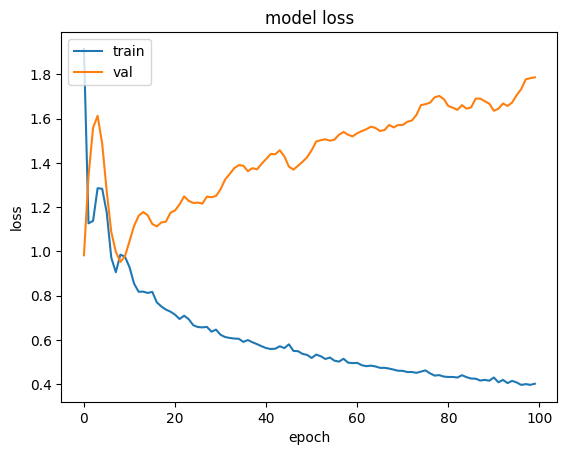

In [64]:

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

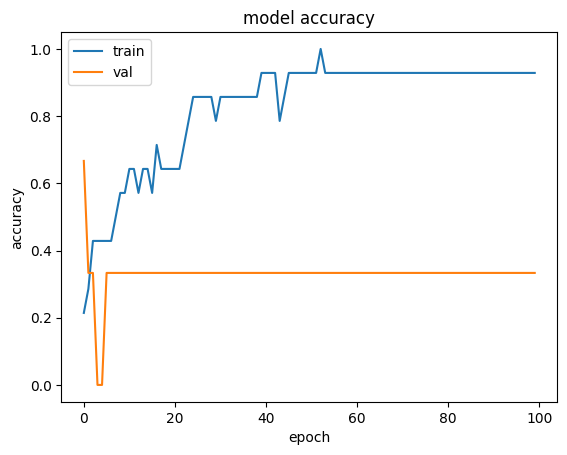

In [65]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

1/1 [==============================] - 0s 22ms/step


/tmp/ipykernel_4163064/1739064555.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


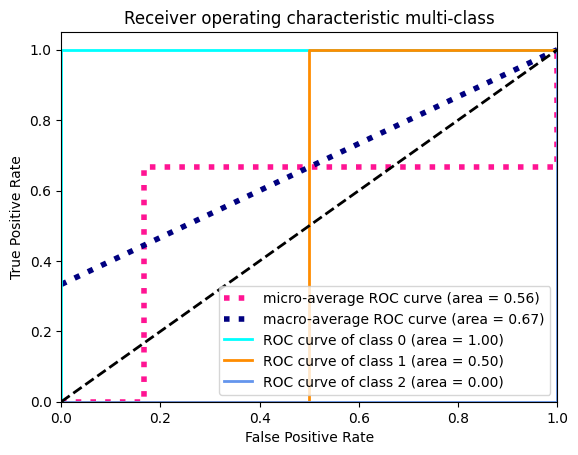

In [66]:
x_test = test_ds
y_test = labels_test
y_score = model.predict(x_test)
y_test = y_test

n_classes = num_classes
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})" "".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})" "".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})" "".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic multi-class")
plt.legend(loc="lower right")
plt.show()

In [67]:
y_classes = np.argmax(y_score, axis=1)
labels_test_f1 = np.argmax(y_test, axis=1)

print(metrics.confusion_matrix(labels_test_f1, y_classes))
print(classification_report(labels_test_f1, y_classes))

[[1 0 0]
 [0 1 0]
 [0 1 0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



/home/user/.conda/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/.conda/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/.conda/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test_f1, y_classes, pos_label=2)
print("AUC: ", metrics.auc(fpr, tpr))

AUC:  0.75
